In [15]:
from google.colab import drive
import pandas as pd
import seaborn as sns
!pip install transformers
!pip install sentencepiece
from transformers import MarianMTModel, MarianTokenizer

drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv("/content/drive/MyDrive/MastersThesis/labeled_ai_data.tsv", sep = '\t')
df = df[0:15]

In [3]:
df.columns

Index(['Unnamed: 0', 'keyword', 'paragraph', 'user', 'labels', 'ID', 'dl_rank',
       'dl_slot', 'title', 'keywords', 'description', 'text', 'timestamp',
       'url', 'paragraph_embedding', 'text_embedding', 'title_embedding',
       'keywords_embedding', 'description_embedding', 'embedding', 'labelmap'],
      dtype='object')

In [4]:
df.drop(['paragraph_embedding', 'text_embedding', 'title_embedding',
       'keywords_embedding', 'description_embedding', 'embedding', 'labelmap'], axis= 1, inplace = True)

##Check the datatypes

In [5]:
df.dtypes

Unnamed: 0      int64
keyword        object
paragraph      object
user           object
labels         object
ID              int64
dl_rank         int64
dl_slot        object
title          object
keywords       object
description    object
text           object
timestamp      object
url            object
dtype: object

##Check the content

In [6]:
df.loc[1]

Unnamed: 0                                                     1
keyword                                  artificial intelligence
paragraph      RPA is a merge of business process automation ...
user                                                      Robert
labels                                                  Know-how
ID                                                    6290260180
dl_rank                                                       59
dl_slot                                          processgold.com
title          Why You Should Implement RPA Together With Pro...
keywords                                                     NaN
description    Implement RPA with Process Mining all together...
text           .  Why You Should Implement RPA Together With ...
timestamp                                    2020-05-26 07:58:20
url            https://processgold.com/blog/why-to-implement-...
Name: 1, dtype: object

##Min and max timestamp

In [7]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2020-05-25 22:18:16
2020-06-03 23:17:14


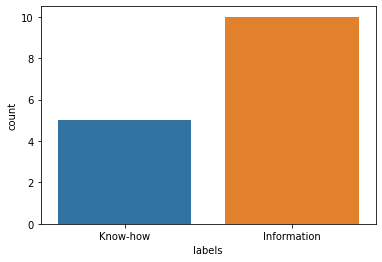

In [8]:
sns.countplot(data = df, x='labels')

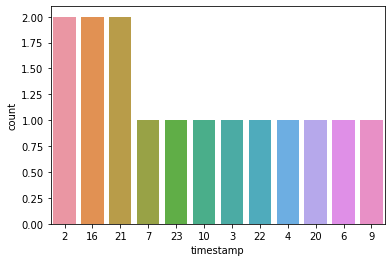

In [9]:
sns.countplot(data = df, x= pd.to_datetime(df['timestamp']).dt.hour, order = pd.to_datetime(df['timestamp']).dt.hour.value_counts().index )

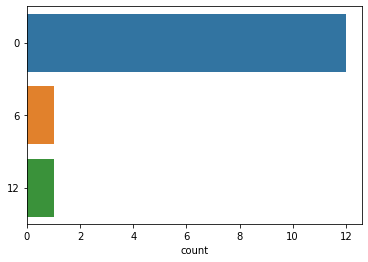

In [10]:
sns.countplot(data = df , y = df.isnull().sum())

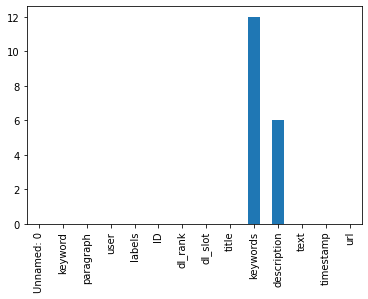

In [11]:
df.isnull().sum().plot(kind = 'bar')

In [12]:
df['labels'].value_counts()

Information    10
Know-how        5
Name: labels, dtype: int64

In [13]:
df = df.fillna(' ')
df[['paragraph', 'keywords', 'description', 'title']]
df['combined_text'] = df[['paragraph', 'keywords', 'description', 'title']].apply(lambda x: ','.join(x.dropna().astype(str)),axis = 1)

In [16]:

# Get the name of the first model
first_model_name = 'Helsinki-NLP/opus-mt-de-en'

# Get the tokenizer
first_model_tkn = MarianTokenizer.from_pretrained(first_model_name)

# Load the pretrained model based on the name
first_model = MarianMTModel.from_pretrained(first_model_name)

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

In [18]:
def format_batch_texts(language_code, batch_texts):
  
  formated_bach = [">>{}<< {}".format(language_code, text) for text in batch_texts]

  return formated_bach

In [ ]:
# format_batch_texts('de',df['combined_text'])

In [17]:
def perform_translation(batch_texts, model, tokenizer, language="en"):
    # Prepare the text data into appropriate format for the model
    formated_batch_texts = format_batch_texts(language, batch_texts)
    
    # Generate translation using model
    translated = model.generate(**tokenizer(formated_batch_texts, return_tensors="pt", padding=True))

    # Convert the generated tokens indices back into text
    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    
    return translated_texts

USing Sentence Embedding 

In [21]:
target = pd.get_dummies(df['labels'])['Information']

In [22]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=c93489bd0783d36e0b7b13715a3f99b644242b3d46e6dd03076411918e6967f9
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [23]:
from sentence_transformers import SentenceTransformer

In [25]:
# df['combined_text'].tolist()

###Baseline model 1
#### No language change used and using mpnet

In [27]:
baseline_model1 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings_bm1 = baseline_model1.encode(df['combined_text'].tolist())
print(embeddings_bm1)

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

[[ 0.01514636 -0.05043139 -0.0162444  ...  0.05393957 -0.07392243
  -0.03777902]
 [ 0.00636284  0.00690515 -0.05694201 ... -0.01299847 -0.01930408
   0.01369929]
 [-0.03830763 -0.03978711  0.02175787 ... -0.01894942 -0.00785616
   0.01190926]
 ...
 [-0.00950329  0.01560879 -0.00435566 ... -0.0015223  -0.02224141
  -0.03473958]
 [-0.00264319 -0.0814492  -0.01518912 ... -0.04535961 -0.05376347
   0.04555847]
 [-0.00269976  0.00668137 -0.03951661 ...  0.05308976 -0.00872378
  -0.03508971]]


###Baseline model 2
####Language translation used and mpnet

## Create backtranslation using 'Helsinki-NLP/opus-mt-de-en'

In [19]:
translated_texts =  perform_translation(df['combined_text'], first_model, first_model_tkn)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1232: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [28]:
baseline_model2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings_bm2 = baseline_model2.encode(translated_texts)
print(embeddings_bm2)

[[ 0.05629862 -0.01799021 -0.04582773 ...  0.02489703 -0.04124964
  -0.04554765]
 [ 0.00318545  0.00761137 -0.05870901 ... -0.01000623 -0.02507687
   0.01580965]
 [ 0.01807516  0.03898433 -0.00323675 ...  0.060394   -0.01745265
  -0.00295012]
 ...
 [-0.00217632  0.04594878 -0.00101303 ... -0.01757527 -0.02630431
   0.01582294]
 [-0.01725897 -0.03763584  0.0093928  ... -0.01773339 -0.00907974
   0.02845676]
 [-0.03010735  0.0560725  -0.02644163 ...  0.02840547  0.00825797
   0.00271352]]


###Baseline Model3 or Multilingual model
####using paraphrase

In [29]:

baseline_model3 = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
embeddings_bm3 = baseline_model3.encode(df['combined_text'].tolist())
print(embeddings_bm3)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

[[ 0.04979563  0.02422276 -0.01096055 ...  0.09200209 -0.11908006
  -0.01728632]
 [-0.05437479  0.00977918 -0.00423016 ... -0.08511917 -0.02510406
   0.04726579]
 [ 0.04549894  0.11912027 -0.0074275  ...  0.09831649  0.02083196
  -0.02027493]
 ...
 [-0.10021526  0.04572918 -0.00988478 ...  0.00424389  0.00371801
   0.01464687]
 [-0.14673795 -0.23537469 -0.00129168 ...  0.0733951  -0.09290829
  -0.08762679]
 [-0.1124707   0.10341359 -0.01211271 ...  0.06554604 -0.03987103
  -0.03362057]]


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
def split(embeddings):

  X_train, X_test, y_train, y_test = train_test_split(embeddings,pd.get_dummies(df['labels'])['Information'] , test_size=0.33, random_state=42)
  return  X_train, X_test, y_train, y_test

###Baseline model1

####Logistic Regression

In [60]:

X_train, X_test, y_train, y_test = split(embeddings_bm1)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='lbfgs', class_weight='balanced').fit(X_train, y_train)
pred = clf.predict(X_test)

#### Confusion Matrix 

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report 
print("====================================================")
print("Confusion matrix")
print(confusion_matrix(y_test, pred))
print("====================================================")
print("Classification Report")
target_names = ['0','1']
report_class = classification_report(y_test, pred, target_names = target_names, zero_division= True)
print(report_class)
print("====================================================")
print("Matthews Corelation coeff")
report_matt = matthews_corrcoef(y_test, pred)
print(report_matt)

Confusion matrix
[[0 2]
 [1 2]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.67      0.57         3

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5

Matthews Corelation coeff
-0.4082482904638631


In [62]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
print ("Accuracy :", np.round(accuracy_score(y_test, pred),5))
print ("Precision :", np.round(precision_score(y_test, pred),5))
print ("Recall :", np.round(recall_score(y_test, pred),5))
print ("f1 score :", np.round(f1_score(y_test, pred),5))
print ("AUC score :", np.round(roc_auc_score(y_test, pred),5))

Accuracy : 0.4
Precision : 0.5
Recall : 0.66667
f1 score : 0.57143
AUC score : 0.33333


###Ensembel Model

In [63]:
from sklearn.ensemble import VotingClassifier
from sklearn import svm
models = [('lr',LogisticRegression()),('svm',svm.SVC())]
ensemble = VotingClassifier(estimators=models,voting='hard')
ensemble.fit(X_train, y_train)
yhat = ensemble.predict(X_test)

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def get_voting():
	# define the base models
	models = list()
	models.append(('LR', LogisticRegression()))
	models.append(('svm', svm.SVC()))

	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble

# get a list of models to evaluate
def get_models():
	models = dict()
	models['LR'] = LogisticRegression()
	models['svm'] = svm.SVC()

	models['hard_voting'] = get_voting()
	return models
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [65]:
from numpy import mean
from numpy import std
# evaluate the models and store results
results, names = list(), list()
models = get_models()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>LR 0.694 (0.039)
>svm 0.694 (0.039)
>hard_voting 0.694 (0.039)


In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report 
print("====================================================")
print("Confusion matrix")
print(confusion_matrix(y_test, yhat))
print("====================================================")
print("Classification Report")
target_names = ['0','1']
report_class = classification_report(y_test, yhat, target_names = target_names, zero_division= True)
print(report_class)
print("====================================================")
print("Matthews Corelation coeff")
report_matt = matthews_corrcoef(y_test, yhat)
print(report_matt)

Confusion matrix
[[0 2]
 [0 3]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.80      0.50      0.37         5
weighted avg       0.76      0.60      0.45         5

Matthews Corelation coeff
0.0


###Baseline Model 2

In [67]:

X_train, X_test, y_train, y_test = split(embeddings_bm2)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='lbfgs', class_weight='balanced').fit(X_train, y_train)
pred = clf.predict(X_test)

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report 
print("====================================================")
print("Confusion matrix")
print(confusion_matrix(y_test, pred))
print("====================================================")
print("Classification Report")
target_names = ['0','1']
report_class = classification_report(y_test, pred, target_names = target_names, zero_division= True)
print(report_class)
print("====================================================")
print("Matthews Corelation coeff")
report_matt = matthews_corrcoef(y_test, pred)
print(report_matt)

Confusion matrix
[[0 2]
 [0 3]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.80      0.50      0.37         5
weighted avg       0.76      0.60      0.45         5

Matthews Corelation coeff
0.0


In [69]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
print ("Accuracy :", np.round(accuracy_score(y_test, pred),5))
print ("Precision :", np.round(precision_score(y_test, pred),5))
print ("Recall :", np.round(recall_score(y_test, pred),5))
print ("f1 score :", np.round(f1_score(y_test, pred),5))
print ("AUC score :", np.round(roc_auc_score(y_test, pred),5))

Accuracy : 0.6
Precision : 0.6
Recall : 1.0
f1 score : 0.75
AUC score : 0.5


In [70]:
from sklearn.ensemble import VotingClassifier
from sklearn import svm
models = [('lr',LogisticRegression()),('svm',svm.SVC())]
ensemble = VotingClassifier(estimators=models,voting='hard')
ensemble.fit(X_train, y_train)
yhat = ensemble.predict(X_test)

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def get_voting():
	# define the base models
	models = list()
	models.append(('LR', LogisticRegression()))
	models.append(('svm', svm.SVC()))

	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble

# get a list of models to evaluate
def get_models():
	models = dict()
	models['LR'] = LogisticRegression()
	models['svm'] = svm.SVC()

	models['hard_voting'] = get_voting()
	return models
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [72]:
from numpy import mean
from numpy import std
# evaluate the models and store results
results, names = list(), list()
models = get_models()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>LR 0.694 (0.039)
>svm 0.694 (0.039)
>hard_voting 0.694 (0.039)


In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report 
print("====================================================")
print("Confusion matrix")
print(confusion_matrix(y_test, yhat))
print("====================================================")
print("Classification Report")
target_names = ['0','1']
report_class = classification_report(y_test, yhat, target_names = target_names, zero_division= True)
print(report_class)
print("====================================================")
print("Matthews Corelation coeff")
report_matt = matthews_corrcoef(y_test, yhat)
print(report_matt)

Confusion matrix
[[0 2]
 [0 3]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.80      0.50      0.37         5
weighted avg       0.76      0.60      0.45         5

Matthews Corelation coeff
0.0


###Basemodel3

In [74]:

X_train, X_test, y_train, y_test = split(embeddings_bm2)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='lbfgs', class_weight='balanced').fit(X_train, y_train)
pred = clf.predict(X_test)

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report 
print("====================================================")
print("Confusion matrix")
print(confusion_matrix(y_test, pred))
print("====================================================")
print("Classification Report")
target_names = ['0','1']
report_class = classification_report(y_test, pred, target_names = target_names, zero_division= True)
print(report_class)
print("====================================================")
print("Matthews Corelation coeff")
report_matt = matthews_corrcoef(y_test, pred)
print(report_matt)

Confusion matrix
[[0 2]
 [0 3]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.80      0.50      0.37         5
weighted avg       0.76      0.60      0.45         5

Matthews Corelation coeff
0.0


In [76]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
print ("Accuracy :", np.round(accuracy_score(y_test, pred),5))
print ("Precision :", np.round(precision_score(y_test, pred),5))
print ("Recall :", np.round(recall_score(y_test, pred),5))
print ("f1 score :", np.round(f1_score(y_test, pred),5))
print ("AUC score :", np.round(roc_auc_score(y_test, pred),5))

Accuracy : 0.6
Precision : 0.6
Recall : 1.0
f1 score : 0.75
AUC score : 0.5


In [77]:
from sklearn.ensemble import VotingClassifier
from sklearn import svm
models = [('lr',LogisticRegression()),('svm',svm.SVC())]
ensemble = VotingClassifier(estimators=models,voting='hard')
ensemble.fit(X_train, y_train)
yhat = ensemble.predict(X_test)

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def get_voting():
	# define the base models
	models = list()
	models.append(('LR', LogisticRegression()))
	models.append(('svm', svm.SVC()))

	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble

# get a list of models to evaluate
def get_models():
	models = dict()
	models['LR'] = LogisticRegression()
	models['svm'] = svm.SVC()

	models['hard_voting'] = get_voting()
	return models
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [79]:
from numpy import mean
from numpy import std
# evaluate the models and store results
results, names = list(), list()
models = get_models()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>LR 0.694 (0.039)
>svm 0.694 (0.039)
>hard_voting 0.694 (0.039)


In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report 
print("====================================================")
print("Confusion matrix")
print(confusion_matrix(y_test, yhat))
print("====================================================")
print("Classification Report")
target_names = ['0','1']
report_class = classification_report(y_test, yhat, target_names = target_names, zero_division= True)
print(report_class)
print("====================================================")
print("Matthews Corelation coeff")
report_matt = matthews_corrcoef(y_test, yhat)
print(report_matt)

Confusion matrix
[[0 2]
 [0 3]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.80      0.50      0.37         5
weighted avg       0.76      0.60      0.45         5

Matthews Corelation coeff
0.0
